Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

# displaying sample images

In [1]:
import retinoto_py as fovea
N_show = 6
args = fovea.Params(batch_size=N_show, do_mask=False, n_val_stop=N_show)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.


Params(image_size=224, do_mask=False, do_fovea=False, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=2018, batch_size=6, num_workers=0, in_memory=True, model_name='convnext_base', do_scratch=False, num_epochs=20, n_train_stop=65536, n_val_stop=6, lr=3e-06, delta1=0.05, delta2=0.01, weight_decay=0.02, label_smoothing=0.03, shuffle=True, verbose=True)

In [2]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
# VAL_DATA_DIR = args.DATAROOT / 'Imagenet_bbox' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=N_show)
val_loader = fovea.get_loader(args, val_dataset)

/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Putting images in memory:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
print(VAL_DATA_DIR)

/Users/laurent/data/Imagenet/Imagenet_full/val


In [4]:
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break

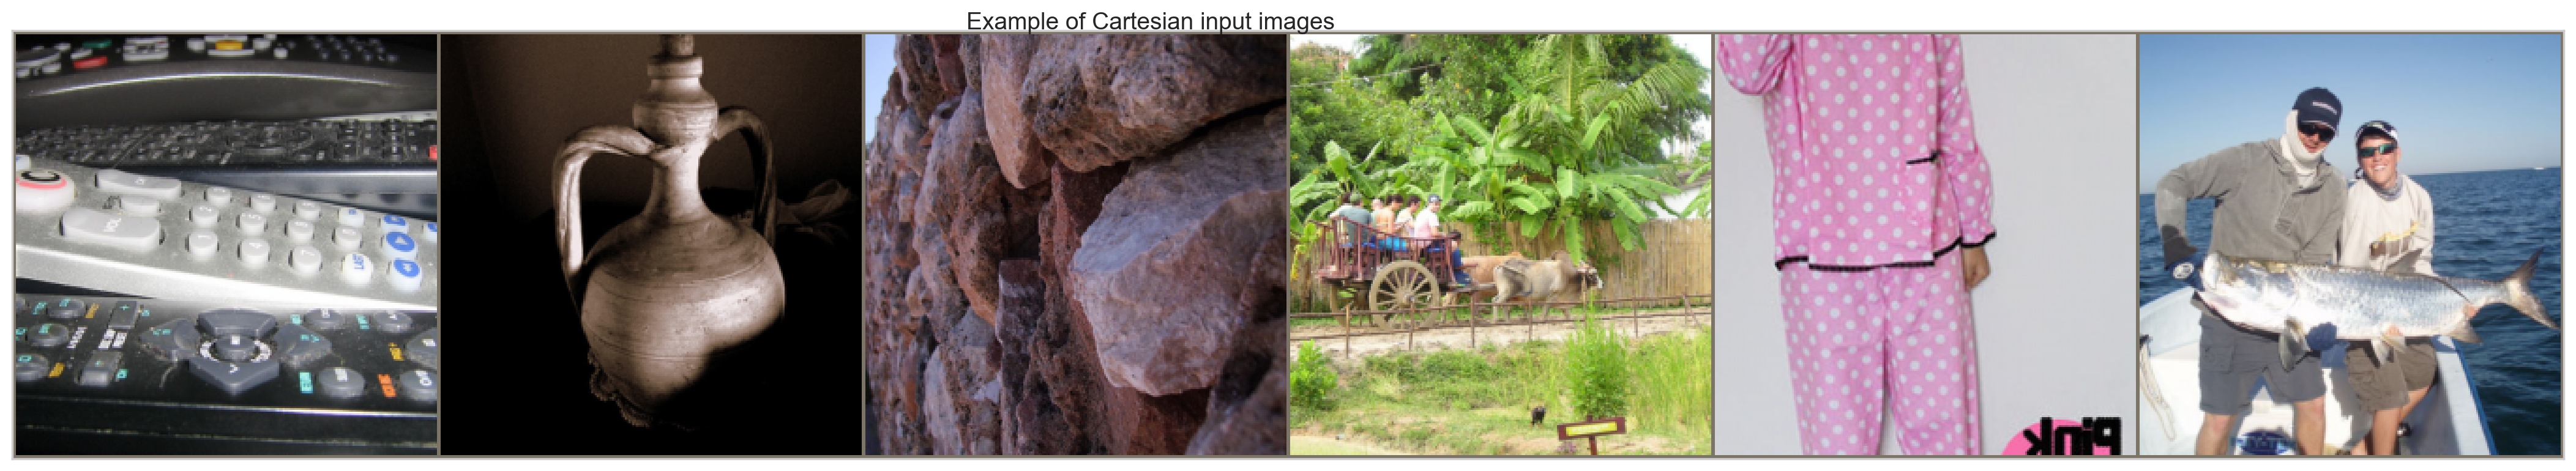

In [5]:
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask

Putting images in memory:   0%|          | 0/6 [00:00<?, ?it/s]

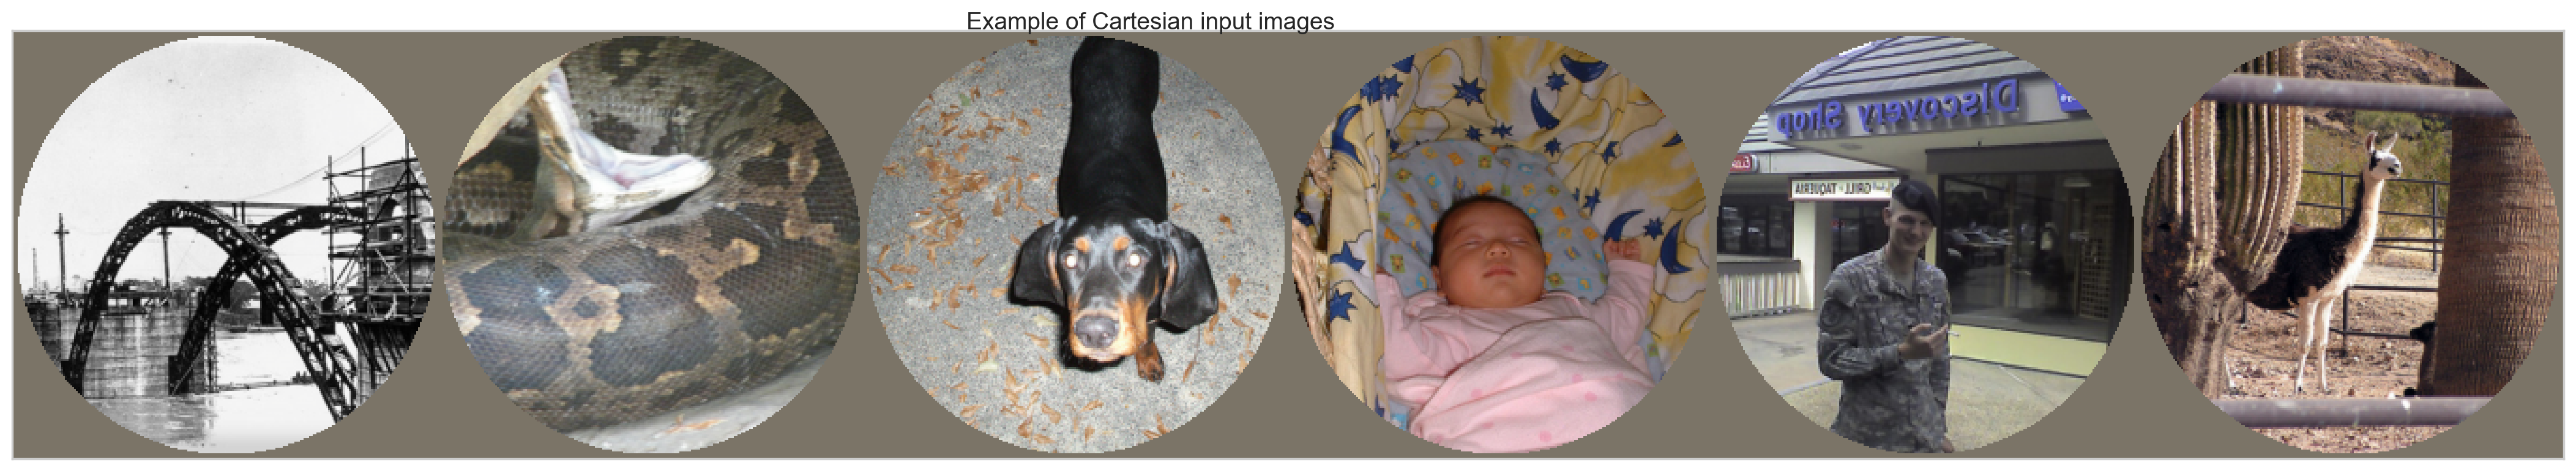

In [6]:
args = fovea.Params(batch_size=N_show, do_mask=True, n_val_stop=N_show)
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=N_show)
val_loader = fovea.get_loader(args, val_dataset)
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask and a rotation

Putting images in memory:   0%|          | 0/6 [00:00<?, ?it/s]

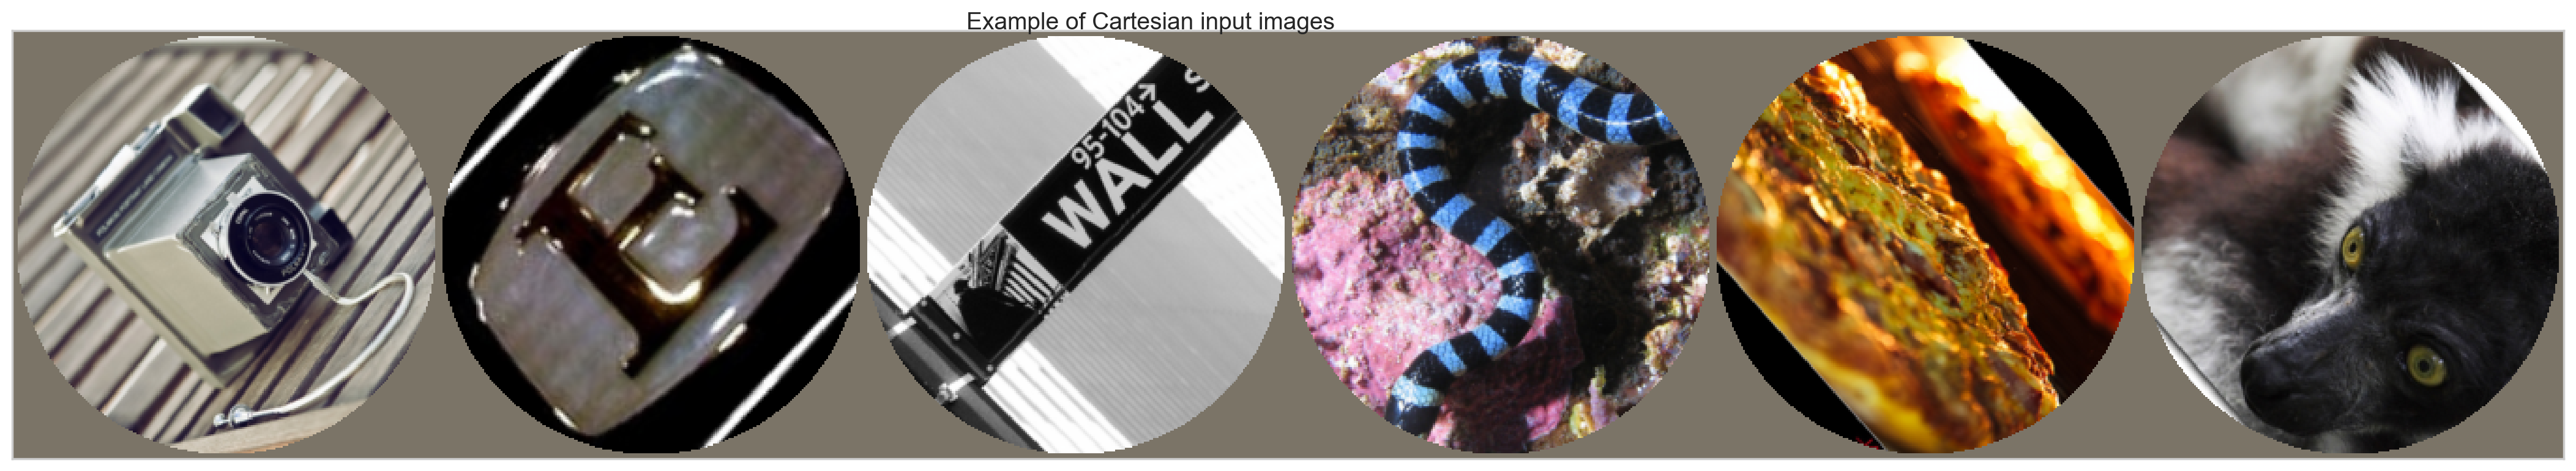

In [7]:
args = fovea.Params(batch_size=N_show, do_mask=True, n_val_stop=N_show)
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, angle_min=40, angle_max=50, n_stop=N_show)
val_loader = fovea.get_loader(args, val_dataset)
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# testing one image at different rotations

In [8]:
seed = 1998
args = fovea.Params(batch_size=1, do_mask=True, shuffle=True, seed=seed, n_val_stop=0, in_memory=False, verbose=True)
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=0)
val_loader = fovea.get_loader(args, val_dataset)
model = fovea.load_model(args)
model.eval()
for i_image, (images, true_labels) in enumerate(val_loader):
    images = images.to(args.device)
    true_labels = true_labels.to(args.device)
    if i_image >= 87: break
images.shape, true_labels


(torch.Size([1, 3, 224, 224]), tensor([589], device='mps:0'))

In [9]:
all_angles = fovea.np.linspace(0, 360, 22) 


In [10]:
all_image_tensors = []
mask = fovea.make_mask(args.image_size).to(args.device)
for _, angle in enumerate(all_angles):
    if _==0: 
        all_image_tensors.append(images * mask)
    else:
        all_image_tensors.append(images[:, 0, 0] * fovea.torch.ones_like(images))
all_images = fovea.torch.cat(all_image_tensors, dim=0)
all_images.shape

torch.Size([22, 3, 224, 224])

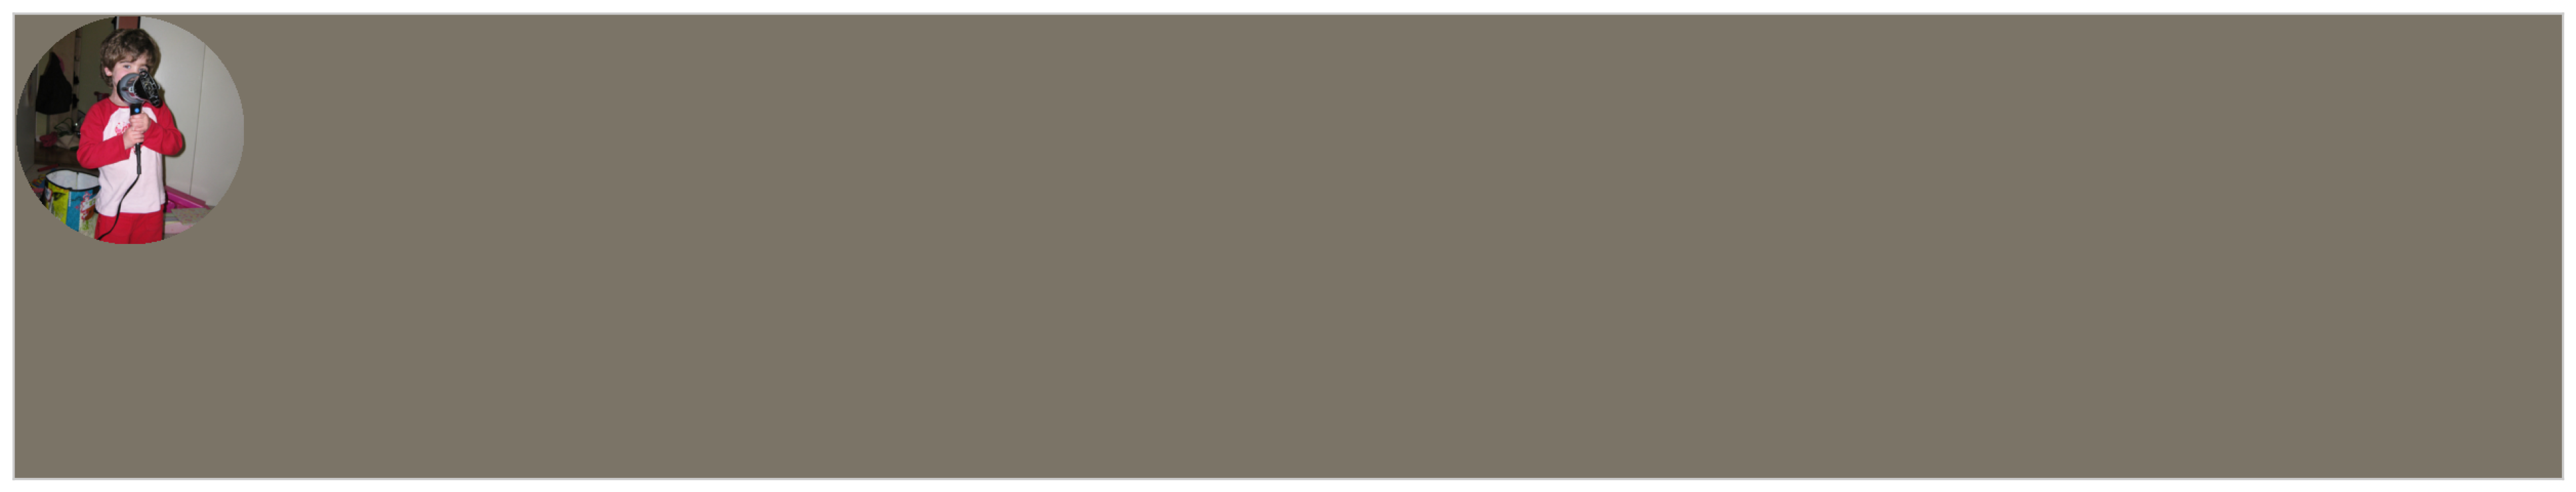

In [11]:
fig, ax = fovea.imshow(all_images.cpu(), fig_height=5)
fovea.savefig(fig, name='16_rotation_attack_sample_rotations_zero', figures_folder=args.figures_folder, exts=['png'])

In [12]:
all_image_tensors = []
all_label_tensors = []

from torchvision.transforms import InterpolationMode

for angle in all_angles:
    image_rot = fovea.TF.rotate(images, angle, interpolation=InterpolationMode.BILINEAR) * mask
    
    # Append the batch of rotated images and their corresponding labels
    all_image_tensors.append(image_rot)
    all_label_tensors.append(true_labels) # Append the full label tensor

# --- AFTER THE LOOP: Concatenate everything at once ---
# This is the efficient way!
all_images = fovea.torch.cat(all_image_tensors, dim=0)
all_labels = fovea.torch.cat(all_label_tensors, dim=0)

all_images.shape, all_labels.shape

(torch.Size([22, 3, 224, 224]), torch.Size([22]))

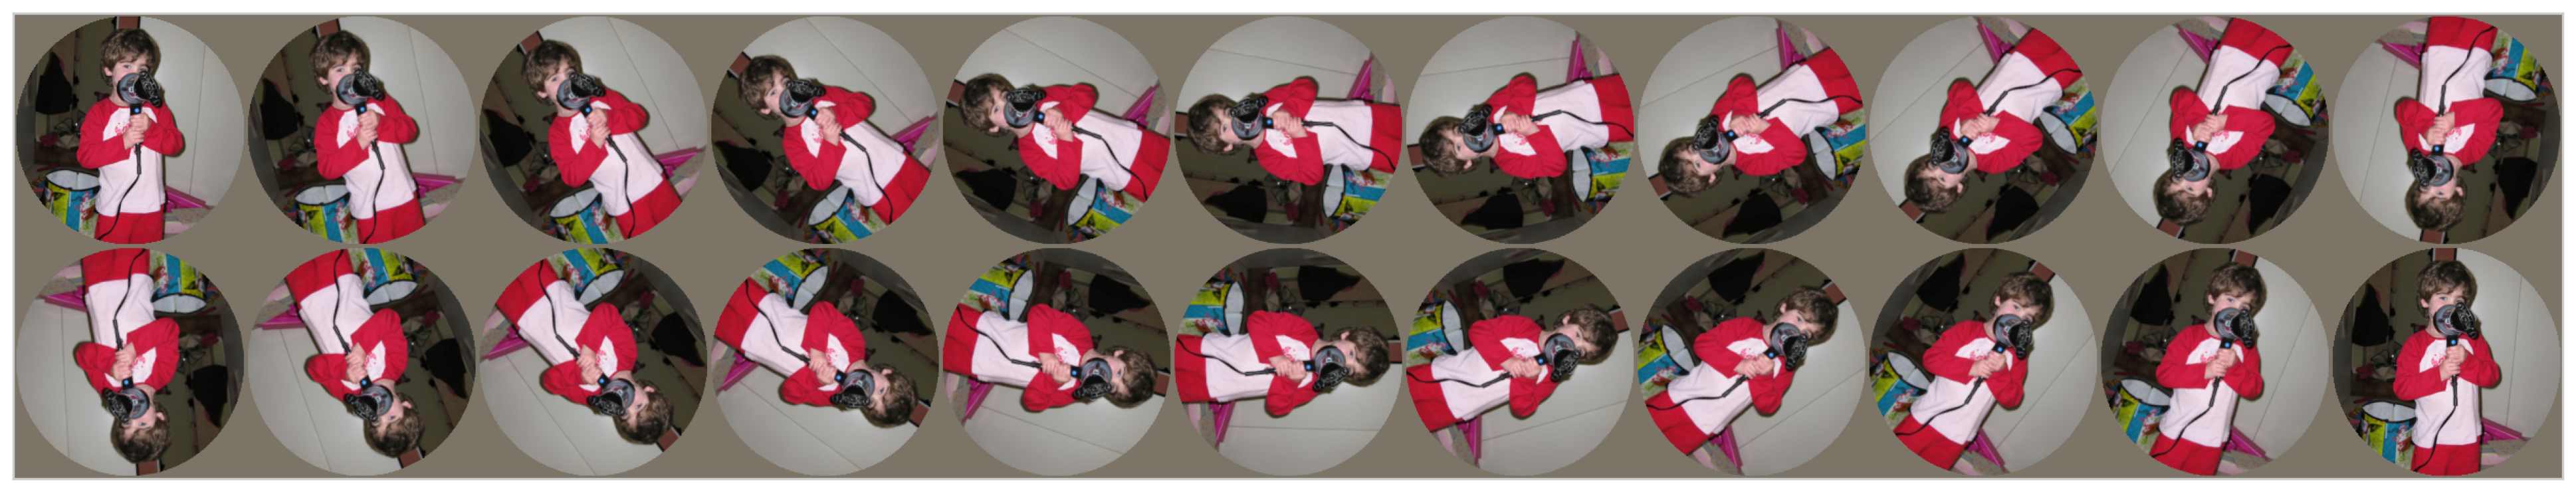

In [13]:
fig, ax = fovea.imshow(all_images.cpu(), fig_height=5)
fovea.savefig(fig, name='16_rotation_attack_sample_rotations', figures_folder=args.figures_folder, exts=['png'])

In [14]:
criterion = fovea.torch.nn.CrossEntropyLoss(reduction='none')
with fovea.torch.no_grad():
    outputs = model(all_images)
    loss = criterion(outputs, all_labels).cpu().numpy()
    logits = outputs.cpu().numpy()

    _, predicted_labels = fovea.torch.max(outputs, dim=1)
    correct_predictions_in_batch = (predicted_labels == all_labels)
predicted_labels, all_labels

(tensor([589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 650, 823, 823, 589, 589, 589, 589, 589], device='mps:0'),
 tensor([589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589], device='mps:0'))

In [15]:
correct_predictions_in_batch, loss

(tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True,
          True,  True,  True], device='mps:0'),
 array([0.50390124, 0.63003486, 0.5654362 , 0.44638884, 0.4184961 ,
        0.52140915, 0.6313703 , 1.6396132 , 0.35427132, 1.1509697 ,
        1.1687806 , 1.8439308 , 0.33596808, 0.6074046 , 2.7028477 ,
        2.7989886 , 2.4470713 , 1.9431603 , 0.84240395, 0.7630786 ,
        0.72160095, 0.50390124], dtype=float32))

In [16]:
worst_angle = loss.argmax()
worst_angle, predicted_labels[worst_angle]

(np.int64(15), tensor(823, device='mps:0'))

In [17]:
idx_to_label = fovea.get_idx_to_label(args)
idx_to_label[predicted_labels[worst_angle]], idx_to_label[all_labels[worst_angle]]

Loading labels from local cache cached_data/imagenet_class_index.json...


('stethoscope', 'hand_blower')

In [18]:
all_images[[0, worst_angle], ...].shape

torch.Size([2, 3, 224, 224])

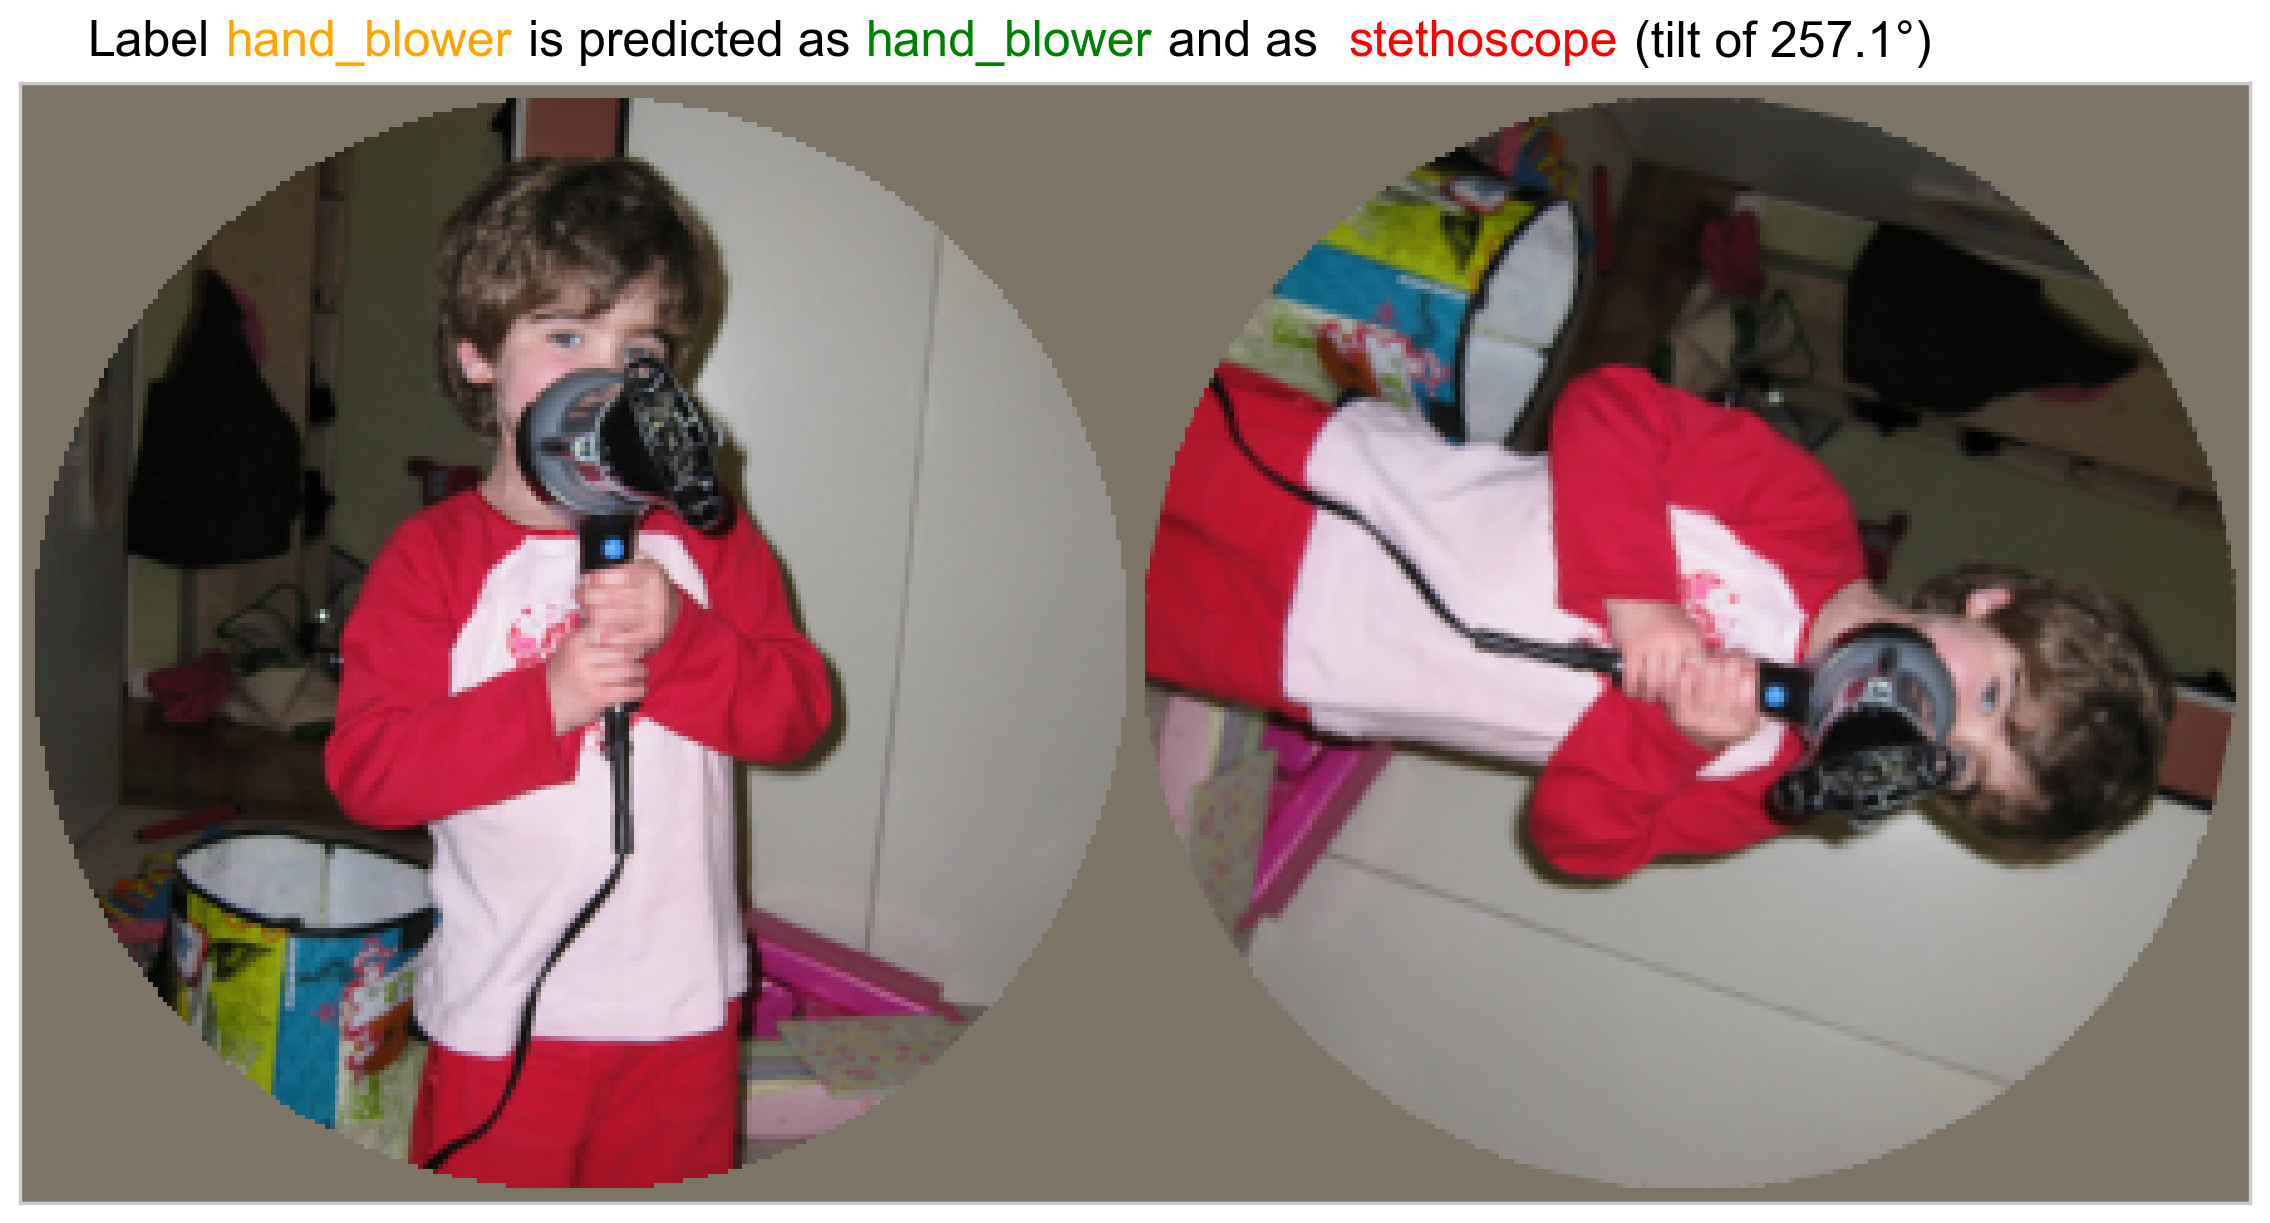

In [19]:
fig_height = 8

def make_title(fig, ax, A, B, C):
    # We position text relative to the FIGURE (0-1), not the axes.
    # This avoids transform complexities.
    transform = fig.transFigure
    
    text_segments = [
        (f"Label", 'black'),
        (f"{A}", 'orange'),
        (f"is predicted as", 'black'),
        (f"{B}", 'green'),
        (f"and as ", 'black'),
        (f"{C}", 'red'),
        (f"(tilt of {all_angles[worst_angle]:.1f}°)", 'black',),
    ]
    
    # Position the title block relative to the figure's width
    x_pos = 0.21 # Start 5% from the left edge of the figure
    y_pos = 0.99  # Start 97% from the bottom of the figure
    font_size = ax.title.get_fontsize() #or plt.rcParams['font.size'] # Get title font size

    for segment, color in text_segments:
        text_obj = fig.text(x_pos, y_pos, segment, color=color, transform=transform, 
                            fontsize=font_size, va='top', ha='left')
        
        # Draw the canvas to ensure the bbox is accurate
        fig.canvas.draw()
        bbox = text_obj.get_window_extent()
        
        # The spacing is now just the width of the text in figure coordinates
        x_pos = (bbox.x1 - fig.bbox.x0) / fig.bbox.width + 0.005 # Add a small space

    return fig, ax


fig, ax = fovea.imshow(all_images[[0, worst_angle], ...].cpu(), title=None, fig_height=fig_height)
fig, ax = make_title(fig, ax, idx_to_label[all_labels[0]], idx_to_label[predicted_labels[0]], idx_to_label[predicted_labels[worst_angle]])
fovea.savefig(fig, name='16_attack', figures_folder=args.figures_folder, exts=['png'])


In [20]:
def one_rotation_attack(image, true_label, all_angles=fovea.np.linspace(0, 360, 22), fig_height = 6):

    all_image_tensors = []
    all_label_tensors = []
    for angle in all_angles:
        image_rot = fovea.TF.rotate(image, angle, interpolation=InterpolationMode.BILINEAR) * mask
        all_image_tensors.append(image_rot)
        all_label_tensors.append(true_label) # Append the full label tensor
    all_images = fovea.torch.cat(all_image_tensors, dim=0)
    all_labels = fovea.torch.cat(all_label_tensors, dim=0)

    with fovea.torch.no_grad():
        outputs = model(all_images)
        loss = criterion(outputs, all_labels).cpu().numpy()
        _, predicted_labels = fovea.torch.max(outputs, dim=1)

    worst_angle = loss.argmax()
    
    fig, ax = fovea.imshow(all_images[[0, worst_angle], ...].cpu(), title=None, fig_height=fig_height)
    fig, ax = make_title(fig, ax, idx_to_label[all_labels[0]], idx_to_label[predicted_labels[0]], idx_to_label[predicted_labels[worst_angle]])
    # fig.tight_layout()

    return fig, ax



In [21]:
n_images = 101
args = fovea.Params(batch_size=1, do_mask=True, shuffle=True, seed=seed, n_val_stop=0, in_memory=False, verbose=True)
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=0)
val_loader = fovea.get_loader(args, val_dataset)
model = fovea.load_model(args)
model.eval()

figures_folder = args.figures_folder / '16_attack'
figures_folder.mkdir(exist_ok=True)
for i_image, (image, true_label) in enumerate(val_loader):
    image = image.to(args.device)
    true_label = true_label.to(args.device)
    fig, ax = one_rotation_attack(image, true_label)
    name =  f'16_attack-{i_image}'
    fovea.savefig(fig, name=name, figures_folder=args.figures_folder / '16_attack', exts=['png'])
    fovea.plt.close() # will close the plot
    print(f'Saved {name}', end='\t')
    if i_image >= n_images: break

Saved 16_attack-0	Saved 16_attack-1	Saved 16_attack-2	Saved 16_attack-3	Saved 16_attack-4	Saved 16_attack-5	Saved 16_attack-6	Saved 16_attack-7	Saved 16_attack-8	Saved 16_attack-9	Saved 16_attack-10	Saved 16_attack-11	Saved 16_attack-12	Saved 16_attack-13	Saved 16_attack-14	Saved 16_attack-15	Saved 16_attack-16	Saved 16_attack-17	Saved 16_attack-18	Saved 16_attack-19	Saved 16_attack-20	Saved 16_attack-21	Saved 16_attack-22	Saved 16_attack-23	Saved 16_attack-24	Saved 16_attack-25	Saved 16_attack-26	Saved 16_attack-27	Saved 16_attack-28	Saved 16_attack-29	Saved 16_attack-30	Saved 16_attack-31	Saved 16_attack-32	Saved 16_attack-33	Saved 16_attack-34	Saved 16_attack-35	Saved 16_attack-36	Saved 16_attack-37	Saved 16_attack-38	Saved 16_attack-39	Saved 16_attack-40	Saved 16_attack-41	Saved 16_attack-42	Saved 16_attack-43	Saved 16_attack-44	Saved 16_attack-45	Saved 16_attack-46	Saved 16_attack-47	Saved 16_attack-48	Saved 16_attack-49	Saved 16_attack-50	Saved 16_attack-51	Saved 16_attack-52	Sav

Voilà !